Reading this on GitHub? [Check out the README in this folder (/notebooks)](https://github.com/StatCan/hackathon-ginyu-force-data/tree/main/notebooks#running-these-notebooks-on-aaw) for instructions on how to run this notebook using the Advanced Analytics Workspace!

# Identifying Duplicates and related projects

We'll start by just doing text-processing and graph based proximity. Ultimately it would make sense to push the terms through Word2Vec or a similar word embedding model, and then we can measure similarity between project names in the embedding in order to detect duplicates or related projects

In [ ]:
using Pkg
Pkg.add("Plots")
Pkg.add("Languages")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Query")
Pkg.add("LightGraphs")
# conda install -c conda-forge flann 
# Pkg.add("SGtSNEpi")
Pkg.add("StatsBase")
Pkg.add("Compose")
Pkg.add("GraphPlot")
Pkg.add("Cairo")
Pkg.add("Fontconfig")

# Lets see if we can identify duplicate or related projects

I.e. "Alberta" and "Government of Alberta" are the same thing. Start by grabbing the data, then we'll filter out articles and stopwords from the names. (i.e. remove "the", "of", etc)

In [281]:
using Languages
using DataFrames
using CSV
using Query
using SparseArrays
using GraphPlot, Compose
import Cairo, Fontconfig

df = CSV.read("../SAMPLE-ESTMA-data.csv", DataFrame)

eng_articles = articles(Languages.English())
eng_stops = stopwords(Languages.English())
simple_filter(x) = !(x in eng_stops || x in eng_articles)

simple_filter (generic function with 1 method)

In [282]:
ENV["COLUMNS"] = 400
first(df, 5)

,estma_id,entity,jurisdiction,period_start_date,period_end_date,reporting_cylce,country,payee_project_name,payee_or_project,payment_category,amount_reported_cad,web_Link,type_of_report,payment_notes
,String,String,String,String,String,Int64,String,String,String,String,String,String?,String,String?
1,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY,payee,Fees,"217,444.04",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,missing
2,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,Government of Mexico,payee,Fees,"2,075.80",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,Corporate tax instalments royalty payments WSIB premiums OMT payments and EHT payments.
3,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,MEXICAN SOCIAL SECURITY INSTITUTE,payee,Taxes,"466,428.68",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,missing
4,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,Estanzuela,project,Fees,"49,299.97",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,Royalties - Includes $208 236 of paid-in-kind royalties valued at realized prices
5,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,Estanzuela,project,Taxes,"348,070.57",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,Alberta Boiler Association Alberta Energy Alberta Energy Regulator Alberta Petroleum & Marketing Commission Bonuses - Alberta Land Sale Auction Royalties - Includes $611 292 of paid-in-kind royalties valued at realized prices


In [283]:
payees_or_projects = unique(df.payee_project_name)

8132-element Vector{String}:
 "GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY"
 "Government of Mexico"
 "MEXICAN SOCIAL SECURITY INSTITUTE"
 "Estanzuela"
 "San Fransisco"
 "Santa Fe"
 "STATE OF NAYARIT"
 "San Francisco"
 "Quebec City Quebec"
 "Qiqavik"
 "West Raglan"
 "City of Ulaanbaatar"
 "Gobi Oyu Development Support Fund"
 ⋮
 "Province of Chumbivilcas"
 "Town of Creighton"
 "Town of Snow Lake"
 "Constancia"
 "Rosemont"
 "Municipal District of Condoroma"
 "Municipal District of Coporaque"
 "Arizona State Government"
 "National Government of Chile"
 "Pima/Santa Cruz County Government"
 "Provincial Government of Manitoba"
 "United States of America Army Corps"

### Apply the filtering and case fixes

In [284]:
# Vectorize and remove articles
vectorized_names = payees_or_projects .|> 
        lowercase .|> 
        split .|> 
        (x -> filter(simple_filter, x))

8132-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["government", "mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "city", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["city", "ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["province", "chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow", "lake"]
 ["constancia"]
 ["rosemont"]
 ["municipal", "district", "condoroma"]
 ["municipal", "district", "coporaque"]
 ["arizona", "government"]
 ["national", "government", "chile"]
 ["pima/santa", "cruz", "county", "government"]
 ["provincial", "government", "manitoba"]
 ["united", "america", "army", "corps"]

## See it in a dataframe

We can group together the old and new terms in a dataframe to see the before-after and also to do a group by

In [285]:
aliases_df = DataFrame(orig = payees_or_projects, vectorized = vectorized_names)

,orig,vectorized
,String,Array…
1,GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY,"[""mining"", ""direction"", ""secretariat"", ""economy""]"
2,Government of Mexico,"[""government"", ""mexico""]"
3,MEXICAN SOCIAL SECURITY INSTITUTE,"[""mexican"", ""social"", ""security"", ""institute""]"
4,Estanzuela,"[""estanzuela""]"
5,San Fransisco,"[""san"", ""fransisco""]"
6,Santa Fe,"[""santa"", ""fe""]"
7,STATE OF NAYARIT,"[""nayarit""]"
8,San Francisco,"[""san"", ""francisco""]"
9,Quebec City Quebec,"[""quebec"", ""city"", ""quebec""]"


In [287]:
length(aliases_df.vectorized) - length(unique(aliases_df.vectorized))

171

### Note: already identified 200 likely duplicates here after removing articles and lowercasing

We can use a groupby on the vectorized column to identify which projects were the same after fixing the case and removing articles

In [288]:
first_aliases = aliases_df |>
    @groupby(_.vectorized) |>
    @filter(x -> length(x) > 1) |>
    @map(x -> [y.orig for y in x]) |>
    collect


155-element Vector{Vector{String}}:
 ["Exploration", "General Exploration"]
 ["City of Calgary", "The City of Calgary"]
 ["Government of Alberta", "Government Of Alberta", "The Government of Alberta"]
 ["Sonora", "State of Sonora"]
 ["Other Projects", "Projects", "Other New Projects"]
 ["Saskatchewan", "Saskatchewan General"]
 ["Indian Oil And Gas Canada", "Indian Oil and Gas Canada"]
 ["Province of Alberta", "Province Of Alberta", "The Province of Alberta"]
 ["Government of the United States", "Government of United States"]
 ["Government of the United States of America", "Government of United States of America"]
 ["State of Nevada", "The State of Nevada"]
 ["State of North Dakota", "North Dakota"]
 ["State of Texas", "State Texas", "Texas"]
 ⋮
 ["Municipality of Villa Nueva", "Municipality Villa Nueva"]
 ["Municipality of Plato", "Municipality Plato"]
 ["Municipality of San Vicente de Chucurri", "Municipality San Vicente de Chucurri"]
 ["Municipality of Simacota", "Municipality Simaco

In [ ]:
length(collect(Iterators.flatten(first_aliases)))

# Let's see if we can identify more duplicates

We're going to start by getting a sense of how much the terms "overlap" with eachother. We could use a fancy metric here to determine how "similar" two vectors are, but we're just going to use a rough heuristic and count how many words they have in common. We'll collect this in an NxN matrix where M[i,j] denotes the count of how many words i and j share. (We'll ignore the diagonal here)

In [289]:
# Count the common number of words
counts(a, b) = length(intersect(a,b))

vnames = unique(aliases_df.vectorized)

7961-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["government", "mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "city", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["city", "ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["province", "chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow", "lake"]
 ["constancia"]
 ["rosemont"]
 ["municipal", "district", "condoroma"]
 ["municipal", "district", "coporaque"]
 ["arizona", "government"]
 ["national", "government", "chile"]
 ["pima/santa", "cruz", "county", "government"]
 ["provincial", "government", "manitoba"]
 ["united", "america", "army", "corps"]

In [290]:
@time begin

width = length(vnames)

m = zeros(Int64, (width, width))

# Symmetric matrix and skip the diagonal
# Still 32000000 entries!!!
for i in 1:width
    for j in (i+1):width
        val = counts(vnames[i], vnames[j])
        val == 0 && continue # skip array allocation if no overlap
        m[i,j] = m[j,i] = val
    end
end
# [counts(a,b) for a in vectorized_names, b in vectorized_names]

end

 72.628507 seconds (475.46 M allocations: 53.678 GiB, 25.31% gc time, 0.01% compilation time)


Now we have our 8000x8000 matrix

In [ ]:
m

#### How many rows have no neighbours?

In [427]:
# Are there any with no neighbors?
count = 0
for i in 1:width
    if max(m[:,1]...) == 0
        count += 1
    end
end

In [428]:
count

0

None!!!!! Every word has a neighbour!

## Very high connectivity!

All the rows are connected to at least one neighbour. Let's see how many neighbours. We'll write a little function to get all words which overlap with a given word (using the matrix we just made)

In [291]:
adjacent(i; v=vnames, m=m) = v[i] => getindex(v, findall(m[:,i] .> 0))

adjacent (generic function with 1 method)

In [293]:
last(adjacent(1))

64-element Vector{Vector{SubString{String}}}:
 ["national", "department", "mining", "produtction"]
 ["saskatchewan", "mining", "assoc."]
 ["saskatchewan", "ministry", "economy"]
 ["oil", "sands", "mining", "upgrading"]
 ["secretary", "economy"]
 ["jurisdictional", "mining", "administrative", "authority"]
 ["bolivian", "jurisdictional", "mining", "administrative", "authority"]
 ["bisha", "mine", "(bisha", "mining", "share", "company)"]
 ["eritrean", "national", "mining", "company", "(enamco)"]
 ["mining", "donation", "equipment/transportation", "electrical", "poles"]
 ["ssr", "mining", "-", "corporate"]
 ["saskatchewan", "mining", "association"]
 ["bathurst", "mining", "camp"]
 ⋮
 ["mcmahon", "mining", "title", "services"]
 ["mining", "title", "services"]
 ["ministry", "economy", "labour", "transport", "lower", "saxony"]
 ["wolfram", "camp", "mining", "pty", "limited"]
 ["minstry", "economy", "regina", "saskatchewan"]
 ["guanajuato", "mining", "complex"]
 ["banro", "congo", "mining", "s

In [ ]:
first(adjacent(1))

### Ahah! It's a few words (in this case "mining") which are super prevalent.

We can see that a lot of project names overlap, but it might be because many projects include one common word (such as "mining"). Lets test this theory.

Let's plot a histogram of the terms, and remove some big ones to make this graph sparser. Like an ad-hoc [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [294]:
using Plots
using StatsBase

In [295]:
all_words = collect(Iterators.flatten(vectorized_names))

22466-element Vector{SubString{String}}:
 "mining"
 "direction"
 "secretariat"
 "economy"
 "government"
 "mexico"
 "mexican"
 "social"
 "security"
 "institute"
 "estanzuela"
 "san"
 "fransisco"
 ⋮
 "chile"
 "pima/santa"
 "cruz"
 "county"
 "government"
 "provincial"
 "government"
 "manitoba"
 "united"
 "america"
 "army"
 "corps"

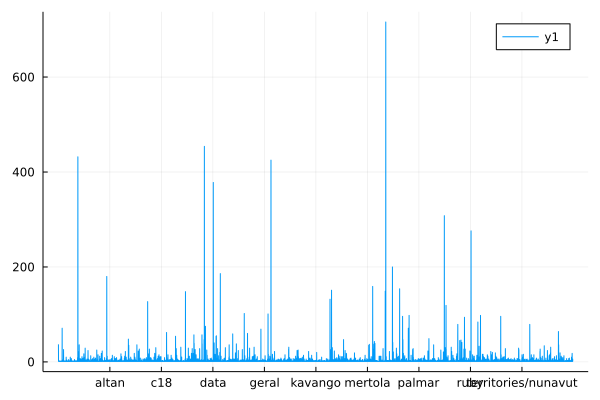

In [429]:
plot(countmap(all_words))

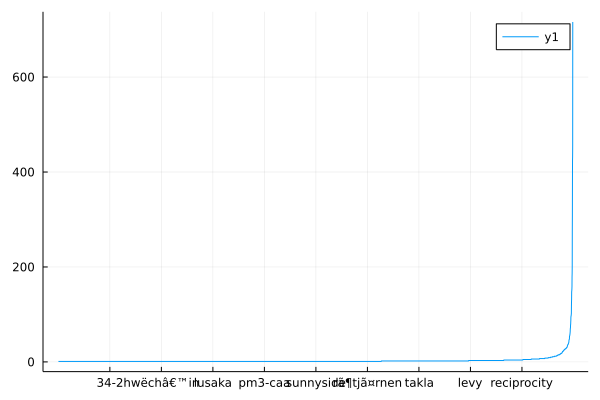

In [430]:
sorted_counts = sort(collect(countmap(all_words)), by=last)

our_words = sorted_counts .|> first
our_counts = sorted_counts .|> last

plot(our_words, our_counts)

### A few very common words

This makes sense! Lets see what they are

In [298]:
word_counts = countmap(all_words)

Dict{SubString{String}, Int64} with 6641 entries:
  "indra"             => 1
  "khanh)"            => 1
  "occitans"          => 1
  "guysborough"       => 4
  "princess"          => 2
  "clamidad"          => 1
  "libertad"          => 4
  "g-cs-02"           => 1
  "ripsey"            => 1
  "135-136"           => 1
  "asturias"          => 4
  "nouveau-brunswick" => 1
  "veta"              => 2
  "henry"             => 2
  "matimekush"        => 1
  "borders"           => 3
  "cubatao"           => 1
  "corihuarmi"        => 1
  "canyon"            => 15
  "star"              => 4
  "kennedale"         => 1
  "ventures"          => 9
  "05"                => 2
  "huaral"            => 2
  "plan"              => 1
  ⋮                   => ⋮

In [299]:
filter(x -> last(x) > 100, word_counts)

Dict{SubString{String}, Int64} with 20 entries:
  "county"       => 454
  "municipal"    => 149
  "nation"       => 200
  "government"   => 425
  "gold"         => 101
  "district"     => 186
  "municipality" => 716
  "alberta"      => 180
  "exploration"  => 102
  "lake"         => 151
  "block"        => 127
  "mine"         => 159
  "no."          => 154
  "rural"        => 276
  "de"           => 378
  "la"           => 132
  "project"      => 308
  "province"     => 119
  "-"            => 432
  "city"         => 148

### Great! We can remove some of these.

Some have semantic meaning (e.g. Alberta), but others, `-` or `municipal`, for instance, do not really contribute too much. We will filter them out and we should be left with a much sparser graph.

In [300]:
removable = filter(x -> last(x) > 100, word_counts) |> keys |> collect

# Only alberta seems important in this list
deleteat!(removable, removable .== "alberta")

19-element Vector{SubString{String}}:
 "county"
 "municipal"
 "nation"
 "government"
 "gold"
 "district"
 "municipality"
 "exploration"
 "lake"
 "block"
 "mine"
 "no."
 "rural"
 "de"
 "la"
 "project"
 "province"
 "-"
 "city"

In [301]:
filtered_vectorized_names = vectorized_names .|> 
    (y -> filter(x -> !(x in removable), y))

aliases_df.filtered = filtered_vectorized_names

8132-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow"]
 ["constancia"]
 ["rosemont"]
 ["condoroma"]
 ["coporaque"]
 ["arizona"]
 ["national", "chile"]
 ["pima/santa", "cruz"]
 ["provincial", "manitoba"]
 ["united", "america", "army", "corps"]

In [302]:
first(aliases_df, 5)

,orig,vectorized,filtered
,String,Array…,Array…
1,GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY,"[""mining"", ""direction"", ""secretariat"", ""economy""]","[""mining"", ""direction"", ""secretariat"", ""economy""]"
2,Government of Mexico,"[""government"", ""mexico""]","[""mexico""]"
3,MEXICAN SOCIAL SECURITY INSTITUTE,"[""mexican"", ""social"", ""security"", ""institute""]","[""mexican"", ""social"", ""security"", ""institute""]"
4,Estanzuela,"[""estanzuela""]","[""estanzuela""]"
5,San Fransisco,"[""san"", ""fransisco""]","[""san"", ""fransisco""]"


You can see here that `Government of Mexico` now maps to `Mexico`

### As we did before, lets identify if any duplicated have appeared

In [303]:
new_duplicates = let 
    old_duplicates = length(aliases_df.vectorized) - length(unique(aliases_df.vectorized))
    cur_duplicates = length(aliases_df.filtered) - length(unique(aliases_df.filtered))
    cur_duplicates - old_duplicates
end

653

#### 603 duplicates!!

In [304]:
second_aliases = aliases_df |>
    @groupby(_.filtered) |>
    @filter(x -> length(x) > 1) |>
    @map(x -> [y.orig for y in x]) |>
    collect

637-element Vector{Vector{String}}:
 ["Government of Mexico", "Exploration Mexico", "State of New Mexico", "New Mexico", "Mexico City", "City of Mexico", "Government of the City of Mexico", "Mexico"]
 ["San Francisco", "San Francisco Mine"]
 ["City of Ulaanbaatar", "Ulaanbaatar City"]
 ["Government of Mongolia", "Exploration - Mongolia"]
 ["Province of Umnugobi", "Umnugobi Province Government"]
 ["Exploration", "Other", "Exploration - Us", "Gold Lake", "Open Lake", "General", "Others", "Long Lake", "Block B", "Municipality of As", "County of Lake County", "Project X", "Got", "General Exploration"]
 ["City of Calgary", "The City of Calgary"]
 ["City of Edmonton", "Edmonton"]
 ["County of Rocky View", "ROCKY VIEW COUNTY", "Municipal District of Rocky View"]
 ["Denton County", "County of Denton"]
 ["Government of Alberta", "Province of Alberta", "Alberta", "Province Of Alberta", "MUNICIPAL GOVERNMENT OF ALBERTA", "Government Of Alberta", "Alberta Government", "Alberta Project", "The Provi

## Let's keep going

We've got the low hanging fruit, but now lets explore the connections between the projects more visually. We'll start by rebuilding the matrix with the new filtered names

In [305]:
fnames = unique(aliases_df.filtered)

7308-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["livitaca"]
 ["velille"]
 ["chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow"]
 ["constancia"]
 ["rosemont"]
 ["coporaque"]
 ["national", "chile"]
 ["pima/santa", "cruz"]
 ["provincial", "manitoba"]
 ["united", "america", "army", "corps"]

In [306]:
@time begin

width = length(fnames)

m = zeros(Int64, (width, width))

# Symmetric matrix and skip the diagonal
# Still 32000000 entries!!!
for i in 1:width
    for j in (i+1):width
        val = counts(fnames[i], fnames[j])
        val == 0 && continue # skip array allocation if no overlap
        m[i,j] = m[j,i] = val
    end
end
# [counts(a,b) for a in vectorized_names, b in vectorized_names]

end

 56.970660 seconds (400.36 M allocations: 44.842 GiB, 27.15% gc time)


## Next lets create some adjacency matrices

You get a 1000x speedup by using SparseArrays. This will let us see projects within N steps of a project

In [357]:
sm = sparse(m)

# Initialize the vector
first_ten = repeat([sm], 10)
for i in 2:10
    first_ten[i] = first_ten[i-1] * sm
end

In [ ]:
g = SimpleGraph(sm)

### We'll build a subgraph of neighbours of a single word

There are 8000 nodes in total, so it's way too many to graph everything. We have to focus on subgraphs.

We'll create an adjacency submatrix (with node labels) and then pass the new matrix to the SimpleGraph object for plotting.

In [421]:
function submatrix(i; mat=sm, labels=fnames)
    indices = Array((mat[:,i]).nzind)
    m = reduce(hcat, [ 
        getindex(mat[:,j], indices) 
        for j in indices
    ])
    
    return Dict(
        :matrix => m,
        :labels => getindex(labels, indices)
    )
end


function plotsubgraph(i; mat=sm, labels=fnames)
    g = submatrix(i)

    labels = [ join(x, " ") for x in g[:labels]]
    
    layout=(args...)->spring_layout(args...; C=20)
    
    gplot(
        SimpleGraph(g[:matrix]); 
        layout=layout, nodesize=1, 
        nodelabeldist=4.8, nodelabelangleoffset=π/4, 
        nodelabel=labels
    )
end



plotsubgraph (generic function with 1 method)

In [431]:
g = plotsubgraph(1)
nothing

In [432]:
draw(SVG("plot1.svg", 60cm, 60cm), g)
fnames[1]

4-element Vector{SubString{String}}:
 "mining"
 "direction"
 "secretariat"
 "economy"

## Graph all neighbours of a given term

The "Root" is excluded from the graph (as it's connected to everything)

## "mining direction secretariat economy"
![plot](plot1.svg)

## Interesting, you can visually see the cluster around "mining"

Let's take a random one and see what happens

In [423]:
# If the random vector is empty, you may need to re-run the cell.
# That's OK, random chance.
row = rand(1:length(fnames))
print("Name: ", join(fnames[row], " "))
g2 = plotsubgraph(row)
draw(SVG("plot5.svg", 60cm, 60cm), g2)

Name: abitibiwinni nations

false

## "abitibiwinni nations"

![plot2](plot5.svg)

This is cool! From the one term you can see that it joins two cliques, the `nations` clique and the `abitibiwinni` clique. The second clique actually does look like its capturing duplicates!!!